# Generate Synthetic images from Ship 3d CAD using Blender Cycles Render

### Install Blender  2.93.5 or new

In [1]:
#Download and install Blender from Blender website. 
#Other Versions are here: https://download.blender.org/release/
#!wget https://download.blender.org/release/Blender2.93/blender-2.93.5-linux-x64.tar.xz
#Unzip Blender 
#!tar xf /blender/blender-2.93.5-linux-x64.tar.xz
#tar xf /blender-2.93.5-linux-x64.tar.xz

### Install Opencv 4.5.4

In [2]:
#!pip3 install scikit-build
#!pip3 install opencv-contrib-python==4.5.4.58
#!pip3 install scipy numpy matplotlib wheel pillow
#!pip3 install wheel numpy scipy matplotlib scikit-image scikit-learn ipython dlib

In [1]:
import os
import cv2
import numpy as np
from PIL import Image , ImageOps
import time
from tqdm import tqdm
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.pyplot import imshow
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
def Matrix2Cross(S):
    return [-S[1,2], S[0,2], -S[0,1]]

def HomogMatrix2twist(H):
    # HomogMatrix2twist Convert 4x4 homogeneous matrix to twist coordinates
    #Input:
    # H(4,4): Euclidean transformation matrix (rigid body motion)
    #Output:
    # twist(6,1): twist coordinates. Stack linear and angular parts [v;w]
    # Observe that the same H might be represented by different twist vectors
    # Here, twist(4:6) is a rotation vector with norm in [0,pi]

    se_matrix = logm(H)

    # careful for rotations of pi; the top 3x3 submatrix of the returned
    # se_matrix by logm is not skew-symmetric (bad).

    v = se_matrix[0:3,3]
    w = Matrix2Cross(se_matrix[0:3,0:3])

    twist = np.array([v[0],v[1],v[2],w[0],w[1],w[2]])

    return twist

def pltShowImg(image):
    fig = plt.figure(dpi=100)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([]) 
    plt.axis('off')
    plt.gcf().canvas.draw()
    
def cv2topilconverter(Idir,Tdir):
    dir1 = Idir + "tmp/000002mask1.png" 
    dir2 = Idir + "tmp/000003mask2.png"  
    dir3 = Idir + "tmp/000004mask3.png"
    Img1 = cv2.imread(dir1,cv2.IMREAD_UNCHANGED)
    ret,Img1 = cv2.threshold(Img1[:,:,3],120,128,cv2.THRESH_BINARY_INV) #THRESH_BINARY
    Img1 = cv2.cvtColor(Img1, cv2.COLOR_GRAY2RGB)
    ret,Img1[:,:,0] = cv2.threshold(Img1[:,:,0],120,192,cv2.THRESH_BINARY)
    #pltShowImg(Img1)

    Img2 = cv2.imread(dir2,cv2.IMREAD_UNCHANGED)
    ret,Img2 = cv2.threshold(Img2[:,:,3],120,128,cv2.THRESH_BINARY) #THRESH_BINARY
    Img2 = cv2.cvtColor(Img2, cv2.COLOR_GRAY2RGB)
    Img2[:,:,1]=0
    ret,Img2[:,:,2] = cv2.threshold(Img2[:,:,2],120,64,cv2.THRESH_BINARY)
    #pltShowImg(Img2)

    Img3 = cv2.imread(dir3,cv2.IMREAD_UNCHANGED)
    ret,Img3 = cv2.threshold(Img3[:,:,3],120,128,cv2.THRESH_BINARY_INV) #THRESH_BINARY
    Img3 = cv2.cvtColor(Img3, cv2.COLOR_GRAY2RGB)
    ret,Img3[:,:,1] = cv2.threshold(Img3[:,:,1],120,64,cv2.THRESH_BINARY)
    Img3[:,:,2]=0
    #pltShowImg(Img3)

    img = Img1+Img2+Img3
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #pltShowImg(img)

    # Existing palette as nested list
    palette = [
        [192, 128, 128],
        [64, 0, 128],
        [0, 64, 128],

    ]
    h, w = img.shape[:2]

    # Generate grayscale output image with replaced values
    img_pal = np.zeros((h, w), np.uint8)
    for i_p, p in enumerate(palette):
        img_pal[np.all(img == p, axis=2)] = i_p
    
    img_pil = Image.fromarray(img_pal)

    # Convert to mode 'P', and apply palette as flat list
    img_pil = img_pil.convert('P')
    palette = [value for color in palette for value in color]
    
    img_pil.putpalette(palette)

    # Save indexed image for comparison
    img_pil.save(Idir + Tdir)

In [3]:
print("Opencv version :",cv2.__version__)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Opencv version : 4.5.4-dev
Tue May 17 13:31:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  6%   45C    P5    N/A / 120W |    535MiB /  1991MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [4]:
Dir = "/home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/"
filename = Dir + 'BlenderCyclesRender/ShipBlenderCycles.blend'
code = Dir + 'BlenderCyclesRender/ShipBlenderCycles.py'
enableGPU = Dir + 'BlenderCyclesRender/GPU.py'
renderer = "CYCLES"
blender = "/home/maneesh/blender-2.93.5-linux-x64/blender"
imgdir = Dir + "CyclesRenderOutput/offline_saved/Train"
Idir = "/home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/CyclesRenderOutput/"

In [5]:
def showimg(image1,image2,scene_i):
    ch = len(np.shape(image1))    
    fig, (ax1, ax2) = plt.subplots(ncols=2,dpi=250)
    
    if ch==3:
        #plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        #ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        #ax2.imshow(image2)
        ax2.imshow(image2,cmap='gray')
        #print(image2.shape)
    elif ch==2:
        ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        #ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        ax2.imshow(image2,cmap='gray')
        #plt.imshow(image, cmap='hot')
    else:
        print('Unsuported image size')
        raise
    ax1.set_title('Scene No : {:06d}'.format(scene_i),fontsize=4)
    #ax1.title("Scene No : ", scene_i)
    plt.xticks([]), plt.yticks([]) 
    ax1.axis('off')
    ax2.axis('off')
    plt.gcf().canvas.draw()

In [6]:
def num_of_img_files_in_folder(dir):
    list = os.listdir(dir) # dir is your directory path
    number_files = len(list)
    return number_files
def resetTimeLog():
    #Reset Time.txt log 
    T = []
    np.savetxt("Time.txt",T)
def resetHLog(Dir):
    #Reset Time.txt log 
    H = []
    np.savetxt(Dir + "tmp/H.txt",H)

In [25]:
def renderRandomScenes(N,Dir):
    imgdir = Dir + "offline_saved/TrainMask/"
    N_img = num_of_img_files_in_folder(imgdir)
    Time = []
    start_time = time.time()
    for scene_i in range(1,N+1):
        scene_i = scene_i + N_img
        #
        # Render synthetic images using blender cycles
        #!$blender -b $filename -P $code --python-use-system-env -E 'CYCLES' 1> nul
        !blender -P $enableGPU -noaudio -b $filename -P $code --python-use-system-env -E 'CYCLES' #1> nul
         
        shipImg = cv2.imread(Dir + 'tmp/{:06d}.png'.format(1))
#         shipImgmask = cv2.imread(Dir +'CyclesRenderOutput/tmp/{:06d}mask.png'.format(2),cv2.IMREAD_UNCHANGED)
#         (T, alpha) = cv2.threshold(shipImgmask[:,:,3], 250, 255, cv2.THRESH_BINARY_INV)
#         alpha = cv2.merge((alpha,alpha,alpha))
        cv2.imwrite(Dir +'offline_saved/Train/{:06d}.png'.format(scene_i),shipImg)
#         cv2.imwrite(Dir + 'CyclesRenderOutput/offline_saved/TrainMask/{:06d}.png'.format(scene_i),alpha)
        #print("alpha = ",alpha.shape)
        Tdir = "offline_saved/TrainMask/{:06d}.png".format(scene_i)
        cv2topilconverter(Dir,Tdir)
#         if scene_i == N+N_img:
#             showimg(shipImg,alpha[:,:,2],scene_i)
            #plt.imshow(alpha, cmap='hot')

        H = np.loadtxt(Dir + "tmp/H.txt")
        tau = HomogMatrix2twist(H)[np.newaxis]
        
        if N_img == 0:
            if scene_i == 1:

                print("Start generating images for the first time because there is no images in the training dataset")
                np.savetxt(Dir + "offline_saved/Tau.txt",tau)
                Tau = tau
            else:
#                 Tau = np.loadtxt(Dir + "offline_saved/Tau.txt")
                Tau = np.concatenate((Tau,tau),axis = 0)
                np.savetxt(Dir + "offline_saved/Tau.txt",Tau)
        if N_img > 0:
            if scene_i == 1+N_img:
                print(N_img, " images already in the training dataset and keep adding images")
                Tau = np.loadtxt(Dir + "offline_saved/Tau.txt")   
            Tau = np.concatenate((Tau,tau),axis = 0)
            np.savetxt(Dir + "offline_saved/Tau.txt",Tau)
        end_time = time.time()
        dt = end_time - start_time
        Time = np.append(Time,dt)
        start_time = end_time
    N_img = num_of_img_files_in_folder(imgdir)
    print(N_img, " images in the training dataset folders")
    
    np.savetxt("Time.txt",Time)
    return Time

def timeProp(N, T, disp = True):
    print("Avg, loop time : ", sum(T)/N, "  (", int(3600/(sum(T)/N)), " images/hour )")
    if disp:
        for scene_i in range(1,N+1):
            print("Scene No ", scene_i, " : ", T[scene_i-1] )
    return 

Blender 3.1.2 (hash cc66d1020c3b built 2022-04-01 00:00:34)
Read prefs: /home/maneesh/.config/blender/3.1/config/userpref.blend
Read blend: /home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/BlenderCyclesRender/ShipBlenderCycles.blend
------------ Selecting Random Image Textures -------------
----------- Rendering --> SynImage_     1...
Info: Total files 7 | Changed 5 | Failed 0
Info: Total files 7 | Changed 5 | Failed 0
highfrequency   2270.jpg   loaded to  Environment Texture
lowfrequency   254.jpg   loaded to  Ship skin Texture
landingpad   73.jpg   loaded to  landingpad
markings   11.jpg   loaded to  markings
highfrequency   981.jpg   loaded to  Wave Texture
################## - - - >>  0 1
Scene No =  1 | Camera Location =  [-1.90610476 -8.37672192  6.02591861] |  FocusUncertinity =  [-2.80737744  5.45632109  0.1       ]
Fra:1 Mem:519.16M (Peak 559.55M) | Time:00:00.62 | Mem:0.00M, Peak:0.00M | Scene, View Layer | Synchronizing object | Wave
Fra:1 Mem:549.68M (Peak 559.55M

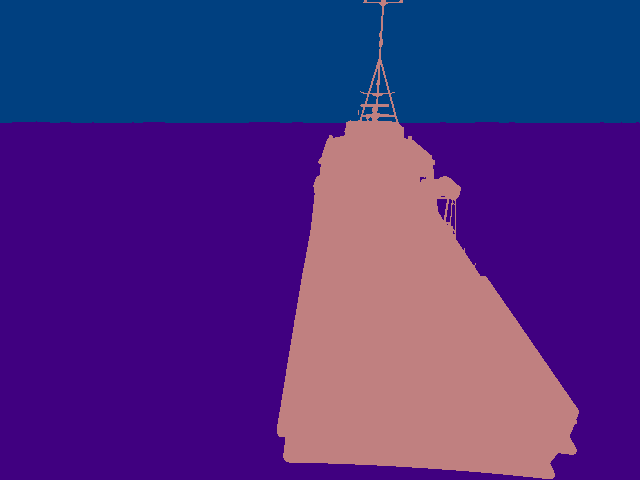

In [32]:
N = 4# Render N number of images online 
start_time = time.time()
Idir = "/home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/CyclesRenderOutput/"
resetTimeLog()
resetHLog(Idir)
T = renderRandomScenes(N,Idir)
#end_time = time.time()
#ltime = end_time - start_time
#print("Total Time : ", np.sum(T) )
#timeProp(N, T, False)
idr = "/home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/CyclesRenderOutput/offline_saved/TrainMask/"
img=idr + "000001.png"
image = Image.open(img).convert('P')

display(image)


In [13]:
T = np.loadtxt('Time.txt')
print("Total time taken for rendering ",len(T), " images : ", np.sum(T)/3600 )
TimeB = np.sum(T)/len(T)
print("Avg.Time taken for rendering : ", TimeB)
print("Generated total synthetic images : ", num_of_img_files_in_folder(imgdir))

Total time taken for rendering  2  images :  0.014746748871273465
Avg.Time taken for rendering :  26.544147968292236
Generated total synthetic images :  19


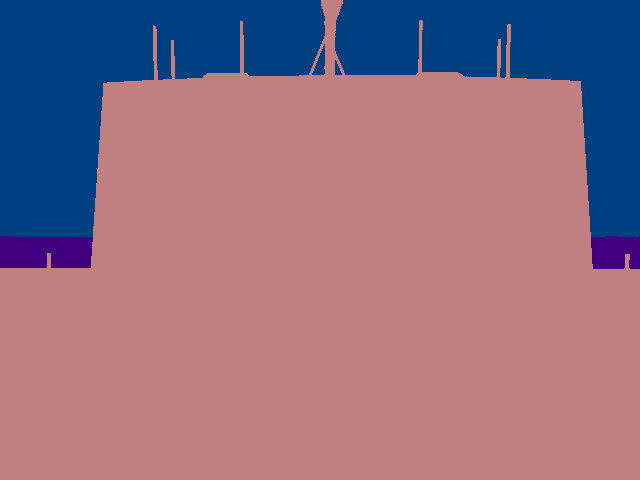

In [17]:

#image = cv2.imread(img)
#for i in range(1,5001):
#   image.save(idr+'{:06d}.png'.format(i))
    #cv2.imwrite("/home/maneesh/Desktop/Syn_Data_Genarate_from_ShipCAD_model/CyclesRenderOutput/offline_saved/TrainMask/{:06d}.png".format(i),image)

#pltShowImg(image)